# Домашнее задание

### ИАД. 2024-2025

### Прогнозирование временных рядов

Мы постарались составить домашнее задание так, чтобы оно помогло закрепить все то, что мы прошли за 2 недели на лекциях и семинарах. Вы вольны использовать любые библиотеки, которые вам нравятся. Главное — это осознанность в выборе методов и интерпретации выводов.

В рамках домашнего задания будем работать с датасетом `NN5`, который можно скачать [здесь](https://zenodo.org/records/4656117). Временные ряды в этом датасете представляют собой данные по ежедневным снятиям наличных в банкоматах в Великобритании.

### Задание 1. Первичный анализ данных (1 балл)

In [1]:
!pip install statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 11.3 MB/s eta 0:00:00


In [2]:
import logging

logger = logging.getLogger(__name__)
import sys

c_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(c_handler)
logging.basicConfig(level=logging.INFO, force=True)

import random
import warnings
from datetime import datetime
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from statsforecast import StatsForecast, models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson

warnings.filterwarnings("ignore")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [3]:
def mase(
    forecast: np.ndarray,
    insample: np.ndarray,
    outsample: np.ndarray,
    frequency: int,
) -> np.ndarray:
    """MASE loss as defined in "Scaled Errors" https://robjhyndman.com/papers/mase.pdf

    Args:
        forecast: Forecast values. Shape: batch, time_o
        insample: Insample values. Shape: batch, time_i
        outsample: Target values. Shape: batch, time_o
        frequency: Frequency value
    Returns:
        Same shape array with error calculated for each time step
    """
    return np.mean(np.abs(forecast - outsample)) / np.mean(
        np.abs(insample[:-frequency] - insample[frequency:])
    )

Нам пригодятся уже знакомые функции с семинаров по чтению рядов в формате tsf. Напомню, что иногда временные ряды могут быть представлены в tsf формате. Это такая структура данных, которая позволяет хранить метаинформацию о временных рядах, а также пары "первая дата — все значения временного ряда".

Функции позволяют считать данные в tsf формате и перевести их в формат, которым мы можем пользоваться.

In [4]:
def convert_tsf_to_dataframe(
    full_file_path_and_name: str,
    replace_missing_vals_with: Any = "NaN",
    value_column_name: str = "series_value",
) -> tuple[pd.DataFrame, str, int, str, str]:
    """
    Конвертирует файл формата TSF в pandas DataFrame.

    Args:
        full_file_path_and_name: Путь к файлу формата TSF.
        replace_missing_vals_with: Значение для замены пропусков.
        value_column_name: Имя столбца для значений временных рядов.

    Returns:
        DataFrame с данными временных рядов.
        Частота данных.
        Прогнозируемый горизонт.
        Содержат ли данные пропуски.
        Равны ли длины временных рядов.

    """
    col_names = []
    col_types = []
    all_data = {}
    all_series = []
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    data_started = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            if line.startswith("@"):
                if line.startswith("@data"):
                    data_started = True
                    # Инициализируем словарь для данных атрибутов
                    for col in col_names:
                        all_data[col] = []
                else:
                    parts = line.split(" ")
                    if line.startswith("@attribute"):
                        col_names.append(parts[1])
                        col_types.append(parts[2])
                    elif line.startswith("@frequency"):
                        frequency = parts[1]
                    elif line.startswith("@horizon"):
                        forecast_horizon = int(parts[1])
                    elif line.startswith("@missing"):
                        contain_missing_values = parts[1].lower() in (
                            "y",
                            "yes",
                            "t",
                            "true",
                            "on",
                            "1",
                        )
                    elif line.startswith("@equallength"):
                        contain_equal_length = parts[1].lower() in (
                            "y",
                            "yes",
                            "t",
                            "true",
                            "on",
                            "1",
                        )
            elif not line.startswith("#") and data_started:
                parts = line.split(":")
                # Последняя часть содержит значения ряда
                series_vals = parts[-1].split(",")
                numeric_series = [
                    replace_missing_vals_with if val == "?" else float(val) for val in series_vals
                ]
                all_series.append(pd.Series(numeric_series).array)
                # Преобразуем и сохраняем значения атрибутов
                for i in range(len(col_names)):
                    if col_types[i] == "numeric":
                        all_data[col_names[i]].append(int(parts[i]))
                    elif col_types[i] == "string":
                        all_data[col_names[i]].append(parts[i])
                    elif col_types[i] == "date":
                        all_data[col_names[i]].append(
                            datetime.strptime(parts[i], "%Y-%m-%d %H-%M-%S")
                        )

    all_data[value_column_name] = all_series
    loaded_data = pd.DataFrame(all_data)
    return loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length


def date_to_daterange(x: pd.Series, freq: str) -> pd.Series:
    """
    Преобразует временные метки в диапазон дат.

    Args:
        x: Временные метки.
        freq: Частота.

    Returns:
        pd.Series с диапазоном дат.

    """
    return pd.Series(pd.date_range(start=x.iloc[0], periods=len(x), freq=freq))


def convert_tsf_to_multivariate_or_standard_format(
    tsf_data_path: str,
    target_column: str = "series_value",
    date_from_column: str = "start_timestamp",
    id_column: str = "series_name",
    # one from ["multivariate", "standard"]
    format: str = "multivariate",
) -> pd.DataFrame:
    """
    Преобразует данные формата TSF в формат pandas DataFrame:
        если format == "standard" -> датафрейм с колонками "id", "date" и "value"
        если format == "multivariate" -> pivot таблица c date в качестве индекса,
            id в качестве колонок и значениями из value_column_name

    Args:
        tsf_data_path: Путь к файлу формата TSF.
        target_column: Имя столбца с целевой переменной.
        date_from_column: Имя столбца с переменной дат.
        id_column: Имя столбца с идентификаторами временных рядов.
        format: Формат данных ("multivariate" или "standard").

    Returns:
        pd.DataFrame с данными в формате "id", "date" и "value".

    """
    FREQ_MAP = {
        "monthly": "MS",
        "10_minutes": "10min",
        "half_hourly": "30min",
        "minutely": "1min",
        "daily": "D",
        "weekly": "7D",
        "yearly": "YS",
        "quarterly": "QS",
        "hourly": "H",
    }

    tsf_df, freq = convert_tsf_to_dataframe(tsf_data_path)[:2]

    # Преобразуем списки в {target_column} в "длинный столбец" со значениями
    tsf_df = tsf_df.explode(target_column)
    # Заменим повторяющиеся значения даты в {date_column} на date_range
    tsf_df["date"] = (
        tsf_df.groupby(id_column, sort=False)[date_from_column]
        .apply(lambda x: date_to_daterange(x, FREQ_MAP[freq]))
        .values
    )
    tsf_df = tsf_df.drop(columns=date_from_column)
    # Переименуем колонки
    tsf_df = tsf_df.rename(columns={id_column: "id", target_column: "value"}).reset_index(
        drop=True
    )
    # Приведем {id_column} к численным значениям
    ids2num = dict(zip(tsf_df["id"].unique(), np.arange(tsf_df["id"].nunique())))
    tsf_df["id"] = tsf_df["id"].map(ids2num)

    if format == "standard":
        return tsf_df
    return pd.pivot_table(tsf_df, values="value", index="date", columns="id")

#### Задание 1.1: Загрузка данных (0 баллов)

Давайте скачаем датасет __NN5__ и загрузим его, воспользовавшись функцией `convert_tsf_to_multivariate_or_standard_format`.

In [5]:
!wget "https://zenodo.org/records/4656117/files/nn5_daily_dataset_without_missing_values.zip?download=1" -O nn5_daily_dataset_without_missing_values.zip
!unzip -o nn5_daily_dataset_without_missing_values.zip
!rm nn5_daily_dataset_without_missing_values.zip

--2025-05-23 12:23:22--  https://zenodo.org/records/4656117/files/nn5_daily_dataset_without_missing_values.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289779 (283K) [application/octet-stream]
Saving to: ‘nn5_daily_dataset_without_missing_values.zip’

nn5_daily_dataset_w 100%[===================>] 282.99K   369KB/s    in 0.8s    

2025-05-23 12:23:23 (369 KB/s) - ‘nn5_daily_dataset_without_missing_values.zip’ saved [289779/289779]

Archive:  nn5_daily_dataset_without_missing_values.zip
  inflating: nn5_daily_dataset_without_missing_values.tsf  


In [6]:
df = convert_tsf_to_multivariate_or_standard_format(
    "nn5_daily_dataset_without_missing_values.tsf", format="standard"
)
df.head()

id      value       date
0   0  13.407029 1996-03-18
1   0  14.725057 1996-03-19
2   0  20.564059 1996-03-20
3   0   34.70805 1996-03-21
4   0  26.629819 1996-03-22

#### Задание 1.2: Типы данных (0.3 балла)

Выведите типы данных в датасете. Проверьте, что они корректные: даты должны быть в формате datetime, id — object, а значения временных рядов — float. Если это не так, то исправьте их.

In [7]:
df.dtypes

id                int64
value            object
date     datetime64[ns]
dtype: object

In [8]:
df = df.astype({'id': 'object', 'value': 'float'})
df.dtypes

id               object
value           float64
date     datetime64[ns]
dtype: object

#### Задание 1.3: Пропуски (0.05 балла)

Проверьте, есть ли в данных пропуски. Если они есть, то заполните их предыдущими значениями. Если пропусков нет, то просто выведите сообщение об этом.

In [9]:
df.isnull().sum()

id       0
value    0
date     0
dtype: int64

#### Задание 1.4: Визуальный анализ временных рядов (0.4 балла)

Постройте линейные графики временных рядов. По оси X отложите время, по оси Y — значения временного ряда.

Используйте Plotly, чтобы можно было отложить сразу все временные ряды на одном графике.

In [10]:
fig = go.Figure()

random_ids = np.random.choice(df["id"].unique(), 10, replace=False)

for i in random_ids:
    fig.add_trace(
        go.Scatter(x=df[df["id"] == i]["date"], y=df[df["id"] == i]["value"], name=str(i))
    )
fig.update_layout(xaxis_title="Date", yaxis_title="Value")
fig.show()

# __Ответьте на следующие вопросы:__
- Какова частотность (frequency) данных?
- Выровнены ли временные ряды?
- Стационарны ли временные ряды? Если нет, то какие признаки нестационарности вы можете выделить?
- На какие группы можно разбить временные ряды по наличию общих признаков? Есть ли что-то, чем похожи все временные ряды?
- Есть ли в рядах выбросы? Как вы можете это определить?

1. Данные имеют ежедневную частотность.
2. Думаю, ряды выровнены, так как визуально у них нет тренда.
3. Временные ряды не стационарны, так как можно наблюдать рост дисперсии при росте t.
4. Достаточно проблематично разделить временные ряды, опираясь лишь на их график. Наверное можно отметить только то, что их дисперсии зависят от времени, а средние значения - нет.
5. Можно сказать, что среди рядов есть выбросы. Можно это определеть с помощью Z-оценки.

#### Задание 1.5: Выделение тестовой выборки (0.25 балла)

Выделите 10% данных для теста, а остальные 90% оставьте для обучения. Делайте это очень аккуратно, чтобы не нарушить временную и многомерную структуру данных!

Вспомните и напишите, в чем особенность выделения тестовой выборки в задаче прогнозирования временных рядов и в задаче прогнозирования __многомерных__ временных рядов.

Обратите внимание, что временные ряды выровнены, а значит, в отличие от семинара, пробегаться в цикле по каждому id не нужно. Подумайте, как можно сделать это более эффективно.

In [11]:
train_size = int(np.round(0.9 * len(df)))
cutoff_date = np.sort(df.date)[train_size]

df_train = df[df.date < cutoff_date]
df_test = df[df.date >= cutoff_date]

При работе с многомерными временными рядами нужно сохранить согласованность по дат. Все ряды должны заканчиваться на одной и той же дате.

In [12]:
for id in df.id.unique():
    print(df[df.id == id])

    id      value       date
0    0  13.407029 1996-03-18
1    0  14.725057 1996-03-19
2    0  20.564059 1996-03-20
3    0  34.708050 1996-03-21
4    0  26.629819 1996-03-22
..  ..        ...        ...
786  0  44.373583 1998-05-13
787  0  65.206916 1998-05-14
788  0  49.744898 1998-05-15
789  0  34.481293 1998-05-16
790  0  32.667234 1998-05-17

[791 rows x 3 columns]
     id      value       date
791   1  11.550454 1996-03-18
792   1  13.591270 1996-03-19
793   1  15.036848 1996-03-20
794   1  21.570295 1996-03-21
795   1  19.444444 1996-03-22
...  ..        ...        ...
1577  1  20.663265 1998-05-13
1578  1  27.097506 1998-05-14
1579  1  32.171202 1998-05-15
1580  1  13.676304 1998-05-16
1581  1  16.369048 1998-05-17

[791 rows x 3 columns]
     id      value       date
1582  2   5.640590 1996-03-18
1583  2  14.399093 1996-03-19
1584  2  24.418934 1996-03-20
1585  2  28.784014 1996-03-21
1586  2  20.620748 1996-03-22
...  ..        ...        ...
2368  2  36.522109 1998-05-13
2369

In [13]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df_train["date"], y=df_train["value"], name="Train", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=df_test["date"], y=df_test["value"], name="Test", line=dict(color="red"))
)
fig.update_layout(
    title="Train/Test Split", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

Не знаю, почему график такой кривой. Вроде поделили нормально, может plotly багнулся

### Задание 2. Полный анализ одного временного ряда (4 баллов)

#### Задание 2.1: Визуальный анализ (0.5 балла)

Выделите из данных временной ряд с номером 92. Постройте его линейный график.

In [14]:
df_train_id_92 = df_train[df_train['id'] == 92]
df_test_id_92 = df_test[df_test.id == 92]

fig = px.line(df_train_id_92, x='date', y='value')
fig.show()

Постройте графики автокорреляций (ACF) и частных автокорреляций (PACF) до 40-го лага для тренировочной выборки.

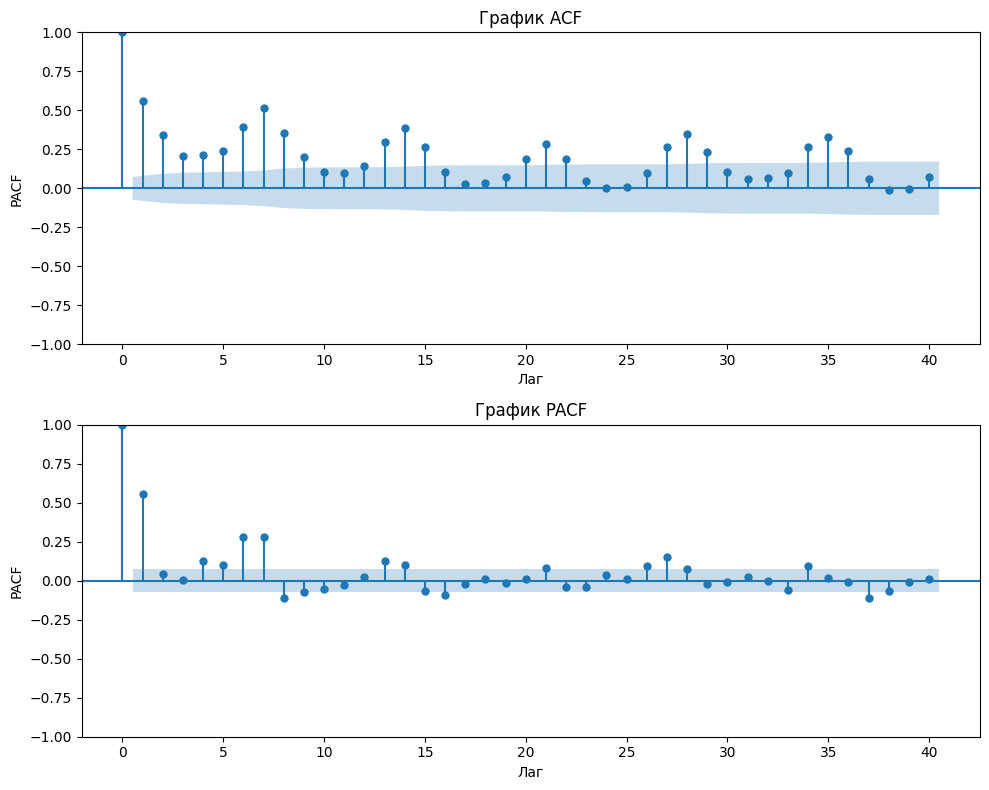

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(df_train_id_92.value, lags=40, ax=ax[0])
ax[0].set_title("График ACF")
ax[0].set_xlabel('Лаг')
ax[0].set_ylabel('PACF')

plot_pacf(df_train_id_92.value, lags=40, ax=ax[1])
ax[1].set_title("График PACF")
ax[1].set_xlabel('Лаг')
ax[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

__Ответьте на следующие вопросы:__
- Стационарен ли временной ряд?
- Присутствует ли в нём тренд? Сезонность? Цикличность?
- Если ряд сезонный, то какой период выглядит наиболее вероятным?

- Ряд не стационарен
- Тренд отсутствует, сезонность и цикличность есть
- Можно выделить недельную сезонность

#### Задание 2.2: Построение модели SARIMA (2 балла)

Пользуясь правилами отсюда: https://people.duke.edu/~rnau/arimrule.html, попробуйте подобрать параметры SARIMA модели, как мы делали это на семинаре.

Не забудьте о возможности использовать предобработку данных, например, логарифмирование и удаление выбросов (самое простое — это воспользоваться IQR: https://medium.com/@divyansh9144/iqr-interquartile-range-for-anomaly-detection-f9c568d1195f).

Если вы используете предобработку, то обязательно укажите, какую именно и почему.

Воспользуемся логарифмированием для уменьшения дисперсии значений ряда. Обязательно добавляем 1 к значениям ряда, так как в нём могут содержаться нулевые значения.

In [16]:
df_train_id_92_log = np.log(df_train_id_92.value + 1)

In [17]:
model = SARIMAX(df_train_id_92_log,
                order=(2, 1, 1), # p=2, тк есть 2 пика на PACF, d=1 для стационарности ряда, q подобрал эмперически
                seasonal_order=(1, 1, 1, 7)) # Ps и Qs подобраны эмпирически. s=7, так как недельная сезонность

model_fit = model.fit(disp=False)
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                  711
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -261.176
Date:                           Fri, 23 May 2025   AIC                            534.351
Time:                                   12:23:43   BIC                            561.683
Sample:                                        0   HQIC                           544.914
                                           - 711                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3285      0.023     14.089      0.000       0.283       0.374
ar.L2          0.1297      0.028      4.565

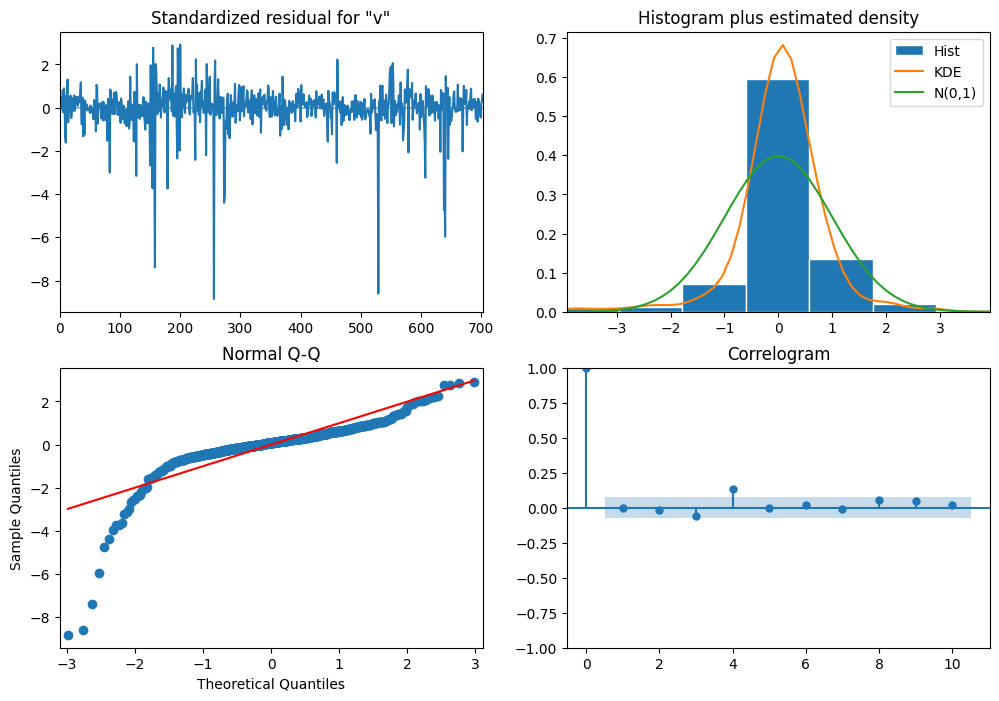

In [18]:
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

#### Задание 2.3: Анализ остатков (0.5 баллов)

Постройте графики ACF и PACF остатков модели SARIMA. Проверьте, что в остатках нет значимых автокорреляций. Если они есть, то попробуйте объяснить, почему это происходит.

Проведите тест на стационарность остатков модели. Проведите тест на автокорреляцию остатков модели. Проинтерпретируйте результаты тестов. Если тесты показывают, что остатки нестационарны или в них есть автокорреляция, то попробуйте объяснить, почему это происходит.

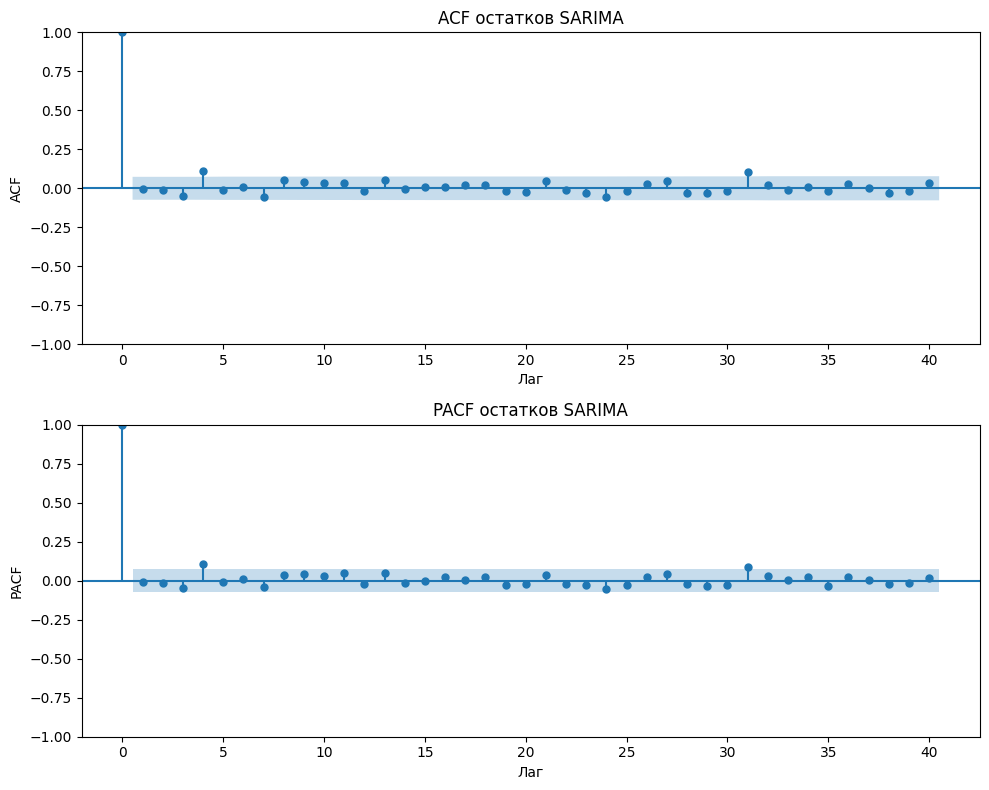

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(model_fit.resid, lags=40, ax=ax[0])
ax[0].set_title("ACF остатков SARIMA")
ax[0].set_xlabel('Лаг')
ax[0].set_ylabel('ACF')

plot_pacf(model_fit.resid, lags=40, ax=ax[1])
ax[1].set_title("PACF остатков SARIMA")
ax[1].set_xlabel('Лаг')
ax[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

Графики ACF и PACF говорят о наличии автокорреляции остатков. Это может возникать из-за неверно подобранных гиперпараметров модели.

In [20]:
adf = adfuller(model_fit.resid)
kps = kpss(model_fit.resid)

In [21]:
print(f"ADF статистика: {np.round(adf[0], 4)}")
print(f"p-value ADF-теста: {np.round(adf[1], 4)}")
print(f"KPSS статистика: {np.round(kps[0], 4)}")
print(f"p-value KPSS-теста: {np.round(kps[1], 4)}")

ADF статистика: -12.7825
p-value ADF-теста: 0.0
KPSS статистика: 0.0791
p-value KPSS-теста: 0.1


In [22]:
dw_stat = durbin_watson(model_fit.resid)
print(f'Статистика теста Дабрина-Уотсона: {dw_stat}')

Статистика теста Дабрина-Уотсона: 1.932949093119657


У теста Дики-Фуллера нулевая гипотеза о наличии единичного корня отвергается, остатки модели стационарны.

P-value KPSS теста > 0.05, принимаем нулевую гипотезу, остатки модели стационарны.

Статистика Дабрина-Уотсона = 1.93 < 2. Имеется положительная автокорреляция остатков.

In [23]:
acorr_ljungbox(model_fit.resid, lags=list(range(1, 16)))

lb_stat  lb_pvalue
1    0.021603   0.883148
2    0.161576   0.922389
3    1.868313   0.600183
4   10.663648   0.030616
5   10.739058   0.056806
6   10.811773   0.094371
7   12.814405   0.076762
8   14.681903   0.065634
9   15.910464   0.068775
10  16.773339   0.079532
11  17.560743   0.092349
12  17.743988   0.123688
13  19.853790   0.098916
14  19.878232   0.134027
15  19.898886   0.175846

На некотором количестве лагов p-value близко к нулю. Из-за этого нулевая гипотеза отвергается, имеется автокорреляция остатков.

#### Задание 2.4: Получение прогнозов и выводы (1 балл)

С помощью полученной модели постройте прогноз на тестовую выборку.

Постройте график прогноза и фактических значений. Сделайте выводы о том, насколько хорошо модель предсказывает временной ряд.

Посчитайте метрику MASE, которую мы имплементировали в начале ноутбука. Объясните, что она показывает и почему ее потенциально полезнее использовать для сравнения моделей, чем MAE или MAPE. Выводы по самому значению метрики делать не нужно.

In [24]:
horizon_of_preds = int(df_test.id.value_counts().values[0])

preds = model_fit.get_forecast(steps=horizon_of_preds)
preds_mean = preds.predicted_mean

preds_exp = np.exp(preds_mean)

In [25]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train_id_92.date,
    y=df_train_id_92.value,
    mode='lines',
    name='Обучающая выборка',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=df_test_id_92.date,
    y=df_test_id_92.value,
    mode='lines',
    name='Тестовая выборка',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=df_test_id_92.date,
    y=preds_exp,
    mode='lines',
    name='Предсказания',
    line=dict(color='green')
))

fig.update_layout(
    title='Результаты модели SARIMA',
    xaxis_title='Дата',
    yaxis_title='Значение',
)
fig.show()

In [26]:
mase_results = mase(preds_exp, df_train_id_92.value.values, df_test_id_92.value.values, 7)
print(f"MASE: {mase_results}")

MASE: 1.0346639220557736


Ну график, скажем честно, прям не очень. Видно, что модель очень плохо предсказывает данные.

MASE сравнивает абсолютную погрешность вашей модели с «базовой» погрешностью наивного сезонно-сдвинутого прогноза. MASE лучше MAE, так как она не зависит от масштаба. При этом она также лучше MAPE, так как она симметрична.

### Задание 3. Построение бейзлайнов на всех рядах и автоматический подбор параметров (2 балла)

#### Задание 3.1: Запуск бейзлайнов (1 балл)
Давайте будем использовать statsforecast для бейзлайнов, так же как мы делали это на семинаре: https://nixtlaverse.nixtla.io/statsforecast/index.html

Постройте прогнозы на всех рядах с помощью следующих бейзлайнов:
- Naive
- Seasonal Naive
- AutoARIMA
- еще 2 на ваш выбор (например, ETS, Theta, TBATS или другие, которые вам нравятся). Кратко опишите суть выбранных моделей.

In [27]:
df_train_values = pd.DataFrame(df_train.values, columns = ["unique_id", "y", "ds"])
df_test_values = pd.DataFrame(df_test.values, columns = ["unique_id", "y", "ds"])

df_train_values.y = df_train_values.y.astype(int)
df_train_values.unique_id = df_train_values.unique_id.astype(str)

df_test_values.y = df_test_values.y.astype(int)
df_test_values.unique_id = df_test_values.unique_id.astype(str)

In [28]:
# просто ETS у меня не заработал

In [29]:
models_comp = StatsForecast(
    models=[
        models.Naive(),
        models.SeasonalNaive(season_length=7),
        models.AutoARIMA(season_length=7),
        models.AutoETS(season_length=7),
        models.Theta(season_length=7)
    ],
    freq="D",
    n_jobs=-1,
    verbose = 1
)

In [30]:
pred_models = models_comp.forecast(df=df_train_values, h=horizon_of_preds)
pred_models

Forecast:   0%|          | 0/111 [Elapsed: 00:00]

unique_id         ds  Naive  SeasonalNaive  AutoARIMA    AutoETS  \
0            0 1998-02-27   62.0           42.0  43.534351  41.860363   
1            0 1998-02-28   62.0           30.0  29.130680  29.200321   
2            0 1998-03-01   62.0           25.0  26.718843  27.914476   
3            0 1998-03-02   62.0           21.0  23.329750  24.815901   
4            0 1998-03-03   62.0           29.0  31.737141  32.544704   
...        ...        ...    ...            ...        ...        ...   
8875        99 1998-05-13   26.0           18.0  13.222132  15.905721   
8876        99 1998-05-14   26.0           26.0  20.304012  22.491148   
8877        99 1998-05-15   26.0           16.0  19.335068  20.980633   
8878        99 1998-05-16   26.0            9.0   9.328538  11.765767   
8879        99 1998-05-17   26.0           10.0  10.583406  13.034240   

          Theta  
0     42.346848  
1     30.890623  
2     30.998755  
3     27.415232  
4     33.139614  
...         ...  
8875  16.113260  
8876  21.567890  
8877  19.705620  
8878  12.411948  
8879  13.319125  

[8880 rows x 7 columns]

#### Задание 3.2: Анализ результатов (1 балл)

Постройте графики фактических значений и прогнозов для всех бейзлайнов для ряда 92. Выведите метрики MASE.

Что можно сказать о каждом из бейзлайнов? Какой из бейзлайнов лучше всего предсказывает временной ряд?

Смогли ли вы руками подобрать гиперпараметры для SARIMA модели лучше, чем автоматический подбор в библиотеке? Если да, то вы огромный молодец! Если нет, то не расстраивайтесь, так бывает.

In [31]:
models_comp_92 = StatsForecast(
    models=[
        models.Naive(),
        models.SeasonalNaive(season_length=7),
        models.AutoARIMA(season_length=7),
        models.AutoETS(season_length=7),
        models.Theta(season_length=7)
    ],
    freq="D",
    n_jobs=-1,
    verbose = 1
)

preds_92 = models_comp_92.forecast(df=df_train_values[df_train_values.unique_id == '92'], h=horizon_of_preds)
preds_92

Forecast:   0%|          | 0/1 [00:00<?, ?it/s]

unique_id         ds  Naive  SeasonalNaive  AutoARIMA    AutoETS      Theta
0         92 1998-02-27   39.0           34.0  33.355583  36.282448  33.133347
1         92 1998-02-28   39.0           23.0  26.635101  26.497204  27.402885
2         92 1998-03-01   39.0           19.0  24.548609  22.388229  25.301844
3         92 1998-03-02   39.0           19.0  24.391291  25.333313  24.937719
4         92 1998-03-03   39.0           22.0  24.808966  24.577024  24.307373
..       ...        ...    ...            ...        ...        ...        ...
75        92 1998-05-13   39.0           26.0  28.014326  27.151558  27.664719
76        92 1998-05-14   39.0           39.0  28.034830  32.784000  32.639534
77        92 1998-05-15   39.0           34.0  28.055336  36.282448  33.739342
78        92 1998-05-16   39.0           23.0  28.075840  26.497204  28.008881
79        92 1998-05-17   39.0           19.0  28.096344  22.388229  25.907839

[80 rows x 7 columns]

In [32]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train_id_92.date,
    y=df_train_id_92.value,
    mode='lines',
    name='Обучающая выборка',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=df_test_id_92.date,
    y=df_test_id_92.value,
    mode='lines',
    name='Тестовая выборка',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=df_test_id_92.date,
    y=preds_92.Naive,
    mode='lines',
    name='Naive',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=df_test_id_92.date,
    y=preds_92.SeasonalNaive,
    mode='lines',
    name='Seasonal Naive',
    line=dict(color='yellow')
))

fig.add_trace(go.Scatter(
    x=df_test_id_92.date,
    y=preds_92.AutoARIMA,
    mode='lines',
    name='ARIMA',
    line=dict(color='green')
))

fig.add_trace(go.Scatter(
    x=df_test_id_92.date,
    y=preds_92.AutoETS,
    mode='lines',
    name='ETS',
    line=dict(color='purple')
))

fig.add_trace(go.Scatter(
    x=df_test_id_92.date,
    y=preds_92.Theta,
    mode='lines',
    name='Theta',
    line=dict(color='pink')
))


fig.update_layout(
    title='Результаты модели SARIMA',
    xaxis_title='Дата',
    yaxis_title='Значение',
)

fig.show()

In [33]:
mase_92 = {}

for i in ['Naive', 'SeasonalNaive', 'AutoARIMA', 'AutoETS', 'Theta']:
  mase_92[i] = [float(mase(preds_92[i], df_train_id_92.value.values, df_test_id_92.value.values, 7))]


pd.DataFrame(mase_92)

Naive  SeasonalNaive  AutoARIMA   AutoETS     Theta
0  2.571256       1.174722   1.354467  1.031645  1.109178

В данном случае лучше всего сработала AutoETS. Ожидалось, что лучшей моделью окажется AutoARIMA, но что-то пошло не так. Возможно свою роль сыграла кривая инициализация модели, потому что в дальнейшем мы увидим, что ARIMA чуть ли не лучшая модель. При этом все остальные модели показали относительно ожидаемые результаты.


Постройте датафрейм с MASE для всех бейзлайнов (агрегированный по всем рядам). Какой из бейзлайнов лучше всего предсказывает временные ряды в нашем датасете? Какой из бейзлайнов хуже всего предсказывает временные ряды в нашем датасете? Как вы думаете, почему так происходит?

In [34]:
mase_results = []

for unique_id in df_test_values.unique_id.unique():
    y_test = df_test_values[df_test_values.unique_id == unique_id]['y'].values
    y_train = df_train_values[df_train_values.unique_id == unique_id]['y'].values
    for model in pred_models.columns[2:]:
        y_pred = pred_models[pred_models.unique_id == unique_id][model].values
        mase_score = mase(y_pred, y_train, y_test, 7)
        mase_results.append({'unique_id': unique_id, 'model': model, 'MASE': mase_score})

In [35]:
df_mases = pd.DataFrame(mase_results)

df_mases.groupby('model')['MASE'].mean()

model
AutoARIMA        0.857793
AutoETS          0.841977
Naive            3.347730
SeasonalNaive    1.004906
Theta            0.854135
Name: MASE, dtype: float64

Лучше всего ряды предсказывает AutoETS, а хуже всего - Naive. Если с худшей моделью всё очевидно, то вот результат лучшей модели, если честно, меня удивил. Возможно мы получили такие результаты, потому что нужно было должным образом подобрать гиперпараметры для ARIMA, хотя в моём понимании, да и документации сказано, что она благодаря приписке Auto модель должна сама подбирать оптимальные гиперпараметры.

Постройте графики фактических значений и прогнозов самого сильного бейзлайна для еще 3-х каких-нибудь рядов и ответьте на следующие вопросы:
- Есть ли среди них такие, которые предсказываются хуже остальных?
- Есть ли среди них такие, которые предсказываются лучше остальных?

In [36]:
np.random.seed(228)
random_ids = np.random.choice(np.unique(df.id), 3, replace=False).tolist()

df_train_random_0 = df_train_values[df_train_values.unique_id == str(random_ids[0])]
df_train_random_1 = df_train_values[df_train_values.unique_id == str(random_ids[1])]
df_train_random_2 = df_train_values[df_train_values.unique_id == str(random_ids[2])]

df_test_random_0 = df_test_values[df_test_values.unique_id == str(random_ids[0])]
df_test_random_1 = df_test_values[df_test_values.unique_id == str(random_ids[1])]
df_test_random_2 = df_test_values[df_test_values.unique_id == str(random_ids[2])]

pred_all_random_0 = pred_models[pred_models.unique_id == str(random_ids[0])]
pred_all_random_1 = pred_models[pred_models.unique_id == str(random_ids[1])]
pred_all_random_2 = pred_models[pred_models.unique_id == str(random_ids[2])]

In [37]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train_random_0.ds,
    y=df_train_random_0.y,
    mode='lines',
    name='Обучающая выборка',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=df_test_random_0.ds,
    y=df_test_random_0.y,
    mode='lines',
    name='Тестовая выборка',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=df_test_random_0.ds,
    y=pred_all_random_0.Naive,
    mode='lines',
    name='Naive',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=df_test_random_0.ds,
    y=pred_all_random_0.SeasonalNaive,
    mode='lines',
    name='Seasonal Naive',
    line=dict(color='yellow')
))

fig.add_trace(go.Scatter(
    x=df_test_random_0.ds,
    y=pred_all_random_0.AutoARIMA,
    mode='lines',
    name='ARIMA',
    line=dict(color='green')
))

fig.add_trace(go.Scatter(
    x=df_test_random_0.ds,
    y=pred_all_random_0.AutoETS,
    mode='lines',
    name='ETS',
    line=dict(color='purple')
))

fig.add_trace(go.Scatter(
    x=df_test_random_0.ds,
    y=pred_all_random_0.Theta,
    mode='lines',
    name='Theta',
    line=dict(color='pink')
))


fig.update_layout(
    title='Результаты модели SARIMA',
    xaxis_title='Дата',
    yaxis_title='Значение',
)

fig.show()

In [38]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train_random_1.ds,
    y=df_train_random_1.y,
    mode='lines',
    name='Обучающая выборка',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=df_test_random_1.ds,
    y=df_test_random_1.y,
    mode='lines',
    name='Тестовая выборка',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=df_test_random_1.ds,
    y=pred_all_random_1.Naive,
    mode='lines',
    name='Naive',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=df_test_random_1.ds,
    y=pred_all_random_1.SeasonalNaive,
    mode='lines',
    name='Seasonal Naive',
    line=dict(color='yellow')
))

fig.add_trace(go.Scatter(
    x=df_test_random_1.ds,
    y=pred_all_random_1.AutoARIMA,
    mode='lines',
    name='ARIMA',
    line=dict(color='green')
))

fig.add_trace(go.Scatter(
    x=df_test_random_1.ds,
    y=pred_all_random_1.AutoETS,
    mode='lines',
    name='ETS',
    line=dict(color='purple')
))

fig.add_trace(go.Scatter(
    x=df_test_random_1.ds,
    y=pred_all_random_1.Theta,
    mode='lines',
    name='Theta',
    line=dict(color='pink')
))


fig.update_layout(
    title='Результаты модели SARIMA',
    xaxis_title='Дата',
    yaxis_title='Значение',
)

fig.show()

In [39]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train_random_2.ds,
    y=df_train_random_2.y,
    mode='lines',
    name='Обучающая выборка',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=df_test_random_2.ds,
    y=df_test_random_2.y,
    mode='lines',
    name='Тестовая выборка',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=df_test_random_2.ds,
    y=pred_all_random_2.Naive,
    mode='lines',
    name='Naive',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=df_test_random_2.ds,
    y=pred_all_random_2.SeasonalNaive,
    mode='lines',
    name='Seasonal Naive',
    line=dict(color='yellow')
))

fig.add_trace(go.Scatter(
    x=df_test_random_2.ds,
    y=pred_all_random_2.AutoARIMA,
    mode='lines',
    name='ARIMA',
    line=dict(color='green')
))

fig.add_trace(go.Scatter(
    x=df_test_random_2.ds,
    y=pred_all_random_2.AutoETS,
    mode='lines',
    name='ETS',
    line=dict(color='purple')
))

fig.add_trace(go.Scatter(
    x=df_test_random_2.ds,
    y=pred_all_random_2.Theta,
    mode='lines',
    name='Theta',
    line=dict(color='pink')
))


fig.update_layout(
    title='Результаты модели SARIMA',
    xaxis_title='Дата',
    yaxis_title='Значение',
)

fig.show()

Исключительно по графикам достаточно сложно сказать, что какой-то конкретный ряд предсказывается лучше или хуже. Но точно можно сказать, что на некоторых рядах модели показывают себя лучше, а на других - хуже. Например для модели Seasonal Naive можно сказать,  что она хорошо справилась с первым рядом, а вот со вторым получилось не очень.

### Задание 4. ML & DL модели (3 балла)

Здесь хочется дать вам полную свободу действий.

Вам нужно будет выбрать одну из ML моделей и одну из DL моделей (старайтесь не повторять один в один решение из семинара, а, если повторяете, то попробуйте, например, перебрать параметры DL модели, оптимизации, препроцессинга / добавить экзогенные признаки (актуально для MIMO стратегии) и т. д.) и построить прогнозы для всех временных рядов на тестовой выборке. __Ваша цель (желательная, но необязательная) — улучшить MASE, полученный с помощью бейзлайнов.__

__Результат задания — мини-отчет по тому, что вы попробовали, что получилось и что не получилось.__ По одному баллу дается за работу с данными (предобработка, генерация дополнительных признаков), за применение ML и DL моделей и интерпретацию полученных с помощью них результатов. Не забудьте кратко описать суть выбранных моделей (особенно, если речь идет о DL моделях).

Вы можете использовать любые модели и библиотеки (`tsfresh` для извлечения признаков, `Tsururu` / `ETNA` / `darts` для использования предобработки, стратегий, моделей и т. д.).

In [40]:
!pip install -U tsururu[catboost]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 889.6/889.6 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.2/75.2 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: holidays
    Found existing installation: holidays 0.72
    Uninstalling holidays-0.72:
      Successfully uninstalled holidays-0.72
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [41]:
from tsururu.dataset import Pipeline, TSDataset
from tsururu.model_training.trainer import MLTrainer
from tsururu.model_training.validator import KFoldCrossValidator, TimeSeriesValidator, HoldOutValidator
from tsururu.models.boost import CatBoost
from tsururu.strategies import FlatWideMIMOStrategy, RecursiveStrategy
from tsururu.models.torch_based.dlinear import DLinear_NN
from tsururu.model_training.trainer import DLTrainer

In [42]:
horizon = 100
history = 100

df_train_ml = []
df_horizon_ml = []
df_test_ml = []

for _id in df.id.unique():
    _df = df[df.id == _id]
    _df.value = np.log(_df.value+1)
    df_train_ml.append(_df.iloc[:-horizon])
    df_horizon_ml.append(_df.iloc[-horizon - history : -horizon])
    df_test_ml.append(_df.iloc[-horizon:])

df_train_ml = pd.concat(df_train_ml)
df_horizon_ml = pd.concat(df_horizon_ml)
df_test_ml = pd.concat(df_test_ml)

params = {
    "id": {"columns": ["id"]},
    "target": {"columns": ["value"]},
    "date": {"columns": ["date"]},
}

train_tsururu = TSDataset(
    data=df_train_ml,
    columns_params=params,
)

horizon_tsururu = TSDataset(
    data=df_horizon_ml,
    columns_params=params,
)

test_tsururu = TSDataset(
    data=df_test_ml,
    columns_params=params,
)

INFO:tsururu.dataset.dataset:freq: Day; period: 1
INFO:tsururu.dataset.dataset:freq: Day; period: 1
INFO:tsururu.dataset.dataset:freq: Day; period: 1


In [43]:
pipeline = Pipeline.easy_setup(params, {'target_lags':1, 'date_lags':7}, multivariate=False)

trainer = MLTrainer(model = CatBoost, validator=KFoldCrossValidator)
strat = RecursiveStrategy(horizon=horizon_of_preds, history=100, trainer = trainer, pipeline=pipeline, step=1)

strat.fit(train_tsururu)
forecast_time, pred_ml = strat.predict(horizon_tsururu)

INFO3:tsururu.models.boost:0:	learn: 0.9831436	test: 1.0183300	best: 1.0183300 (0)	total: 82.4ms	remaining: 1m 22s
DEBUG:tsururu.models.boost:100:	learn: 0.7278061	test: 0.7617721	best: 0.7617721 (100)	total: 3.68s	remaining: 32.7s
DEBUG:tsururu.models.boost:200:	learn: 0.7100411	test: 0.7454789	best: 0.7454789 (200)	total: 7.49s	remaining: 29.8s
DEBUG:tsururu.models.boost:300:	learn: 0.6998210	test: 0.7383013	best: 0.7383013 (300)	total: 12.3s	remaining: 28.7s
DEBUG:tsururu.models.boost:400:	learn: 0.6923293	test: 0.7344999	best: 0.7344999 (400)	total: 15.4s	remaining: 23s
DEBUG:tsururu.models.boost:500:	learn: 0.6862697	test: 0.7322115	best: 0.7322115 (500)	total: 18.3s	remaining: 18.2s
DEBUG:tsururu.models.boost:600:	learn: 0.6806143	test: 0.7298243	best: 0.7298243 (600)	total: 19.4s	remaining: 12.9s
DEBUG:tsururu.models.boost:700:	learn: 0.6759932	test: 0.7286196	best: 0.7285983 (698)	total: 20.5s	remaining: 8.73s
DEBUG:tsururu.models.boost:800:	learn: 0.6720862	test: 0.7276104	bes

In [44]:
import torch

In [45]:
if torch.cuda.is_available:
    device = 'cuda'
else:
    device = 'cpu'


In [46]:
model = DLinear_NN
model_params = {"moving_avg": 5}

validation = KFoldCrossValidator
validation_params = {
    "n_splits": 3,
}

trainer_params = {
    "device": device,
    "num_workers": 0,
    "best_by_metric": True,
    "save_to_dir": False,
    "n_epochs": 3
}

trainer = DLTrainer(
    model,
    model_params,
    validation,
    validation_params,
    **trainer_params
)

In [47]:
strat_nn = RecursiveStrategy(
    pipeline=pipeline,
    trainer=trainer,
    horizon=horizon_of_preds,
    history=70,
)

strat_nn.fit(train_tsururu)
forecast_nn, pred_nn = strat_nn.predict(horizon_tsururu)

INFO:tsururu.model_training.trainer:length of train dataset: 45954
INFO:tsururu.model_training.trainer:length of val dataset: 22977
INFO:tsururu.model_training.trainer:Epoch 1/3, cost time: 117.30s
INFO:tsururu.model_training.trainer:train loss: 0.6583
INFO:tsururu.model_training.trainer:Validation, Loss: 0.6305, Metric: -0.6305
INFO:tsururu.model_training.trainer:val loss: 0.6305, val metric: -0.6305
INFO:tsururu.model_training.trainer:Epoch 2/3, cost time: 117.48s
INFO:tsururu.model_training.trainer:train loss: 0.6322
INFO:tsururu.model_training.trainer:Validation, Loss: 0.6272, Metric: -0.6272
INFO:tsururu.model_training.trainer:val loss: 0.6272, val metric: -0.6272
INFO:tsururu.model_training.trainer:Epoch 3/3, cost time: 119.53s
INFO:tsururu.model_training.trainer:train loss: 0.6321
INFO:tsururu.model_training.trainer:Validation, Loss: 0.6304, Metric: -0.6304
INFO:tsururu.model_training.trainer:val loss: 0.6304, val metric: -0.6304
INFO:tsururu.model_training.torch_based.callbacks


Постройте графики фактических значений и прогнозов для всех бейзлайнов для ряда 92. Постройте графики фактических значений и прогнозов для 3-х рядов из предыдущего задания. Стали ли прогнозы лучше отражать реальность?

In [48]:
pred_nn_92 = pred_nn[pred_nn.id == 92]
pred_nn_92.value = np.exp(pred_nn_92.value.astype(float))
pred_ml_92 = pred_ml[pred_ml.id == 92]
pred_ml_92.value = np.exp(pred_ml_92.value.astype(float))

pred_nn_0 = pred_nn[pred_nn.id == random_ids[0]]
pred_nn_1 = pred_nn[pred_nn.id == random_ids[1]]
pred_nn_2 = pred_nn[pred_nn.id == random_ids[2]]

pred_nn_0.value = np.exp(pred_nn_0.value.astype(float))
pred_nn_1.value = np.exp(pred_nn_1.value.astype(float))
pred_nn_2.value = np.exp(pred_nn_2.value.astype(float))

pred_ml_0 = pred_ml[pred_ml.id == random_ids[0]]
pred_ml_1 = pred_ml[pred_ml.id == random_ids[1]]
pred_ml_2 = pred_ml[pred_ml.id == random_ids[2]]

pred_ml_0.value = np.exp(pred_ml_0.value.astype(float))
pred_ml_1.value = np.exp(pred_ml_1.value.astype(float))
pred_ml_2.value = np.exp(pred_ml_2.value.astype(float))

In [49]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train_id_92.date,
    y=df_train_id_92.value,
    mode='lines',
    name='Обучающая выборка',
    line=dict(color='blue')
))


fig.add_trace(go.Scatter(
    x=df_test_id_92.date,
    y=df_test_id_92.value,
    mode='lines',
    name='Тестовая выборка',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=pred_ml_92.date,
    y=pred_ml_92.value,
    mode='lines',
    name='CatBoost',
    line=dict(color='purple')
))

fig.add_trace(go.Scatter(
    x=pred_nn_92.date,
    y=pred_nn_92.value,
    mode='lines',
    name='DLinear',
    line=dict(color='green')
))

fig.update_layout(
    title='ML and DL results',
    xaxis_title='Дата',
    yaxis_title='Значение',
)

fig.show()

In [50]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train_id_92.date,
    y=df_train_id_92.value,
    mode='lines',
    name='Обучающая выборка',
    line=dict(color='blue')
))


fig.add_trace(go.Scatter(
    x=df_test_id_92.date,
    y=df_test_id_92.value,
    mode='lines',
    name='Тестовая выборка',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=pred_ml_0.date,
    y=pred_ml_0.value,
    mode='lines',
    name='CatBoost',
    line=dict(color='purple')
))

fig.add_trace(go.Scatter(
    x=pred_nn_0.date,
    y=pred_nn_0.value,
    mode='lines',
    name='DLinear',
    line=dict(color='green')
))

fig.update_layout(
    title='ML and DL results',
    xaxis_title='Дата',
    yaxis_title='Значение',
)

fig.show()

In [51]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train_id_92.date,
    y=df_train_id_92.value,
    mode='lines',
    name='Обучающая выборка',
    line=dict(color='blue')
))


fig.add_trace(go.Scatter(
    x=df_test_id_92.date,
    y=df_test_id_92.value,
    mode='lines',
    name='Тестовая выборка',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=pred_ml_1.date,
    y=pred_ml_1.value,
    mode='lines',
    name='CatBoost',
    line=dict(color='purple')
))

fig.add_trace(go.Scatter(
    x=pred_nn_1.date,
    y=pred_nn_1.value,
    mode='lines',
    name='DLinear',
    line=dict(color='green')
))

fig.update_layout(
    title='ML and DL results',
    xaxis_title='Дата',
    yaxis_title='Значение',
)

fig.show()

In [52]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train_id_92.date,
    y=df_train_id_92.value,
    mode='lines',
    name='Обучающая выборка',
    line=dict(color='blue')
))


fig.add_trace(go.Scatter(
    x=df_test_id_92.date,
    y=df_test_id_92.value,
    mode='lines',
    name='Тестовая выборка',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=pred_ml_2.date,
    y=pred_ml_2.value,
    mode='lines',
    name='CatBoost',
    line=dict(color='purple')
))

fig.add_trace(go.Scatter(
    x=pred_nn_2.date,
    y=pred_nn_2.value,
    mode='lines',
    name='DLinear',
    line=dict(color='green')
))

fig.update_layout(
    title='ML and DL results',
    xaxis_title='Дата',
    yaxis_title='Значение',
)

fig.show()

In [61]:
mase_results_ml = mase(pred_ml_92.value.values, df_train_id_92.value.values, df_test_id_92.value.values, 7)
mase_results_nn = mase(pred_nn_92.value.values, df_train_id_92.value.values, df_test_id_92.value.values, 7)

print(f"MASE with Catboost: {mase_results_ml}")
print(f"MASE with DLinear: {mase_results_nn}")

MASE with Catboost: 1.7188299311714432
MASE with DLinear: 1.6784734711521172


Если честно, я не смог нормально разобраться в библиотеке, поэтому просто взяли из неё готовые CatBoost и DLinear, накинул рекурсивную стратегию прогнозирования и надеялся получить хорошие результаты. Помимо всего прочего я сделал логарифмирование ряда. Тажке для обеих моделей в  качестве валидатора была использована стратегия KFolds.

Если говорить о результатах полученных моделей, то наверное нельзя их назвать хотя бы удовлетворительными. В случае некоторых рядов очевидно то, что модели занижали предсказания и не могли подстроиться под данные. При этом, в случаях 92 и 3 рядов обе модели проявили себя достаточно неплохо.